### adapted from locuslab/TCN

#### importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import csv
import re
from matplotlib import cm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import random

In [2]:
from ray import tune

In [3]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

#### data cleaning

In [4]:
def data_cleaning(path, pattern_interest): 
    # reading in the data
    data = pd.read_csv(path,header=0)
    # sorting data in dataframe
    df1 = pd.DataFrame(data)
    
    #getting only the step 11 related variables
    step11vars = [col for col in df1.columns if col.split('.')[0] == '11']
    df2 = df1.loc[:, df1.columns.isin(step11vars)]
    
    # getting only the faceplate, bottom heater and heater outerzone related variables within the step11 dataset

    # bottom heater related
    bottom_related = [col for col in df2.columns if 'Bottom' in col]
    dfb = df2.loc[:, df2.columns.isin(bottom_related)]

    # faceplate related
    faceplate_related = [col for col in df2.columns if "Faceplate" in col]
    dff = df2.loc[:, df2.columns.isin(faceplate_related)]

    # heater outer-zone related
    outer_related = [col for col in df2.columns if "HeaterOuter" in col]
    dfo = df2.loc[:, df2.columns.isin(outer_related)]
    
    # heater exchanger related
    hx_related = [col for col in df2.columns if "HX" in col]
    dfx = df2.loc[:, df2.columns.isin(hx_related)]
    
    # heater exchanger related
    inner_related = [col for col in df2.columns if "HeaterInner" in col]
    dfi = df2.loc[:, df2.columns.isin(inner_related)]
    
    # merge the three keywords related datasets together into `dfall`
    dfall = pd.concat([dfb, dff, dfo, dfx, dfi], axis=1)
    
    mean_related = [col for col in dfall.columns if "mean" in col]
    dfmean = dfall.loc[:, dfall.columns.isin(mean_related)]
    
    #Xbotmean = dfmean[dfmean.columns.drop(list(dfmean.filter(regex='11.FaceplateHeater_Temperature.mean')))]
    Xmean = dfmean[dfmean.columns.drop(list(dfmean.filter(regex=pattern_interest)))]
    ymean = dfmean.loc[:,[pattern_interest]]
    
    return Xmean, ymean

#### TCN module

In [5]:
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

#### upper level of the TCN model

In [6]:
from torch import nn
import torch.nn.functional as F

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights() # if the data needs to be weighted

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)  # if multidimensional, input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return o

#### data generator for the adding problem

In [7]:
from torch.autograd import Variable

def data_generator(percent_train, seq_length, path):
    
    """
    Args:
        seq_length: Length of the adding problem data
        starting_index: the index of where the sequence starts; starting from 0
    """
    # Specifying the feature columns that we need for predictions
    col1 = '11.BottomHeater_Temperature.mean'
    col2 = '11.FaceplateHeater_Temperature.mean'
    col3 = '11.HeaterOuterZone_Temperature.mean'
    col = [col1, col2, col3]
    
    # Giving the path to the data set
    csv = path
    
    # Data cleaning, getting the feature matrix and 
    X_bot, y_bot = data_cleaning(csv, col1)
    
    X_bot = torch.tensor(X_bot.to_numpy()).float()
    y_bot = torch.tensor(y_bot.to_numpy()).float()
    print("converted X_bot ", X_bot.shape, "and y_bot ", y_bot.shape, " to tensors\n")
    
    X_bot1 = torch.reshape(X_bot, [1, X_bot.shape[1], X_bot.shape[0]]) #[1,14,274]
    y_bot1 = torch.reshape(y_bot, [1, y_bot.shape[0]]) #[1,274]

    first_test_idx = int(round(percent_train * X_bot.shape[0]))
    X_train = X_bot1[:, :, 0:first_test_idx]
    X_test = X_bot1[:, :, first_test_idx:]
    y_train = y_bot1[:, 0:first_test_idx]
    y_test = y_bot1[:, first_test_idx:]
    
    X_train_final = torch.zeros([X_train.shape[2]-seq_length, X_train.shape[1], seq_length]) #[196, 14, 10] = [206-10, 14, 10]
    y_train_final = torch.zeros([y_train.shape[1]-seq_length, 1]) #[196, 1] = [206-10, 1]
    X_test_final = torch.zeros([X_test.shape[2]-seq_length, X_test.shape[1], seq_length]) #[58, 14, 10] = [68-10, 14, 10]
    y_test_final = torch.zeros([y_test.shape[1]-seq_length, 1]) #[58,1] = [68-10, 1]
    
    for i in range(X_train.shape[2]-seq_length):
        X_train_final[i, :, :] = X_train[: , : , i:i+seq_length]
        y_train_final[i, :] = y_train[: , i+seq_length:i+seq_length+1]
        
    for i in range(X_test.shape[2]-seq_length):
        X_test_final[i, :, :] = X_test[: , : , i:i+seq_length]
        y_test_final[i, :] = y_test[: , i+seq_length:i+seq_length+1]
#         print("at index i = ", i, "y_test[1, ", i+seq_length, "] = ",y_test[: , i+seq_length:i+seq_length+1])
#         print("at index i = ", i, "y_test_final[",i, ", :] = ", y_test_final[i, :])

    
#     print("Y_train shape is set to: ", y_train_final.shape, "; Y_train type is: ", type(y_train_final), "\n")
#     print("X_train shape is set to: ", X_train_final.shape, "; X_train type is: ", type(X_train_final), "\n")
#     print("Y_test shape is set to: ", y_test_final.shape, "; Y_test type is: ", type(y_test_final), "\n")
#     print("X_test shape is set to: ", X_test_final.shape, "; X_test type is: ", type(X_test_final), "\n")    
    
    return Variable(X_train_final), Variable(y_train_final), Variable(X_test_final), Variable(y_test_final)

#### parameters needed for the program

In [8]:
input_channels = 14 # # of input features
n_classes = 1  #size of each output sample; output feature sizes of y_pred
batch_size = 32 #batch size defaults to 32
seq_length = 10 #sequence length; defaults to 400
epochs = 15 #upper epoch limit; defaults to 10
clip = -1 #args.clip; gradient clip, -1 means no clip (default: -1)
log_interval = 100 #args.log_interval; 'report interval (default: 100')
channel_sizes = [30]*8 #[args.nhid]*args.levels; number of hidden units per layer * # of levels
kernel_size = 7 #args.ksize; kernel_size
dropout =  0.0 #args.dropout; dropouts applied to each layer; defaults to 0.0
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)
lr = 4e-3 # learning rate is defaulted to be 0.0040
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)

In [9]:
percent = 0.7
X_train, Y_train, X_test, Y_test = data_generator(percent, seq_length, r"C:\Users\e177321\Documents\data\Marathon_data.csv")
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

converted X_bot  torch.Size([274, 14]) and y_bot  torch.Size([274, 1])  to tensors

torch.Size([182, 14, 10]) torch.Size([182, 1]) torch.Size([72, 14, 10]) torch.Size([72, 1])


#### training

In [10]:
def train(epoch, input_channels=14):
    global lr
    
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
            
        #print("x.shape = ", x.shape, "y.shape = ", y.shape)
        optimizer.zero_grad()
        output = model(x)
        loss = torch.nn.functional.mse_loss(output, y)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % log_interval == 0:
            cur_loss = total_loss / log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0

#### testing

In [11]:
def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = torch.nn.functional.mse_loss(output, Y_test)
        f, ax = plt.subplots()
        #print("Y_pred values: ", output, "\n")
        ax.scatter(Y_test, output,  color='black')
        ax.set_xlabel('Outputs from Marathon data')
        ax.set_ylabel('Outputs from predictions')
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return ax


Test set: Average loss: 1182.285400


Test set: Average loss: 3471.479980


Test set: Average loss: 1941.944458


Test set: Average loss: 896.006348


Test set: Average loss: 246.958176


Test set: Average loss: 47.559528


Test set: Average loss: 5.878748


Test set: Average loss: 22.783772


Test set: Average loss: 25.730307


Test set: Average loss: 16.945137


Test set: Average loss: 7.074117


Test set: Average loss: 2.979357


Test set: Average loss: 0.845411


Test set: Average loss: 0.416284


Test set: Average loss: 0.150587



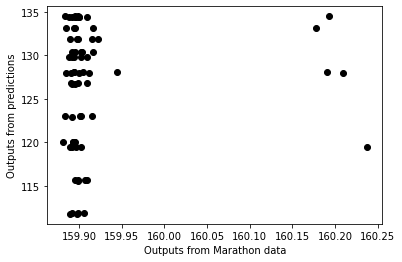

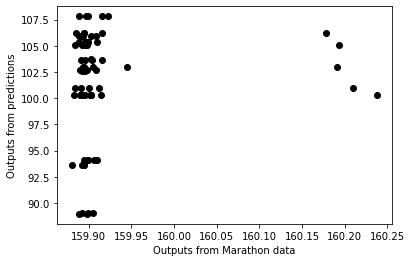

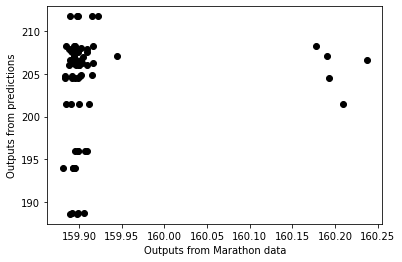

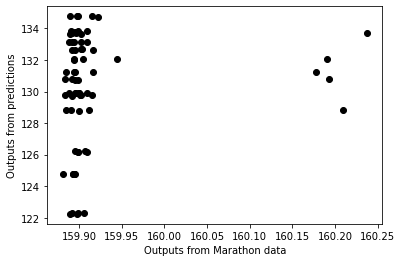

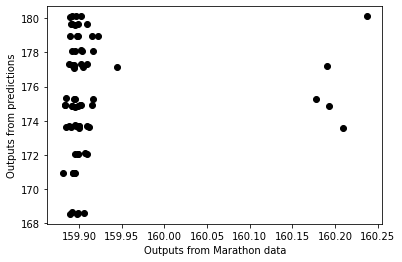

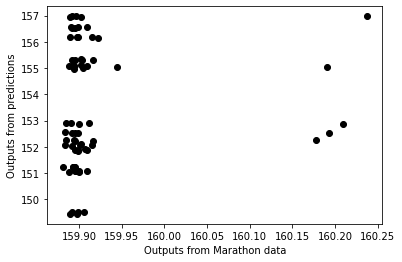

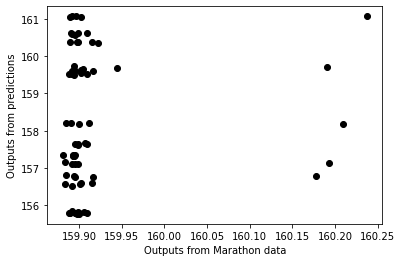

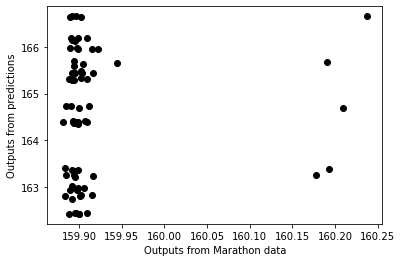

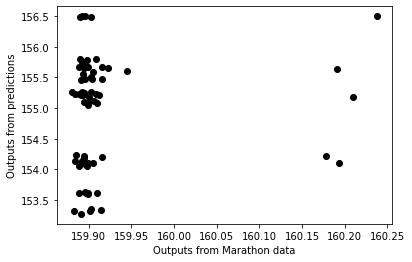

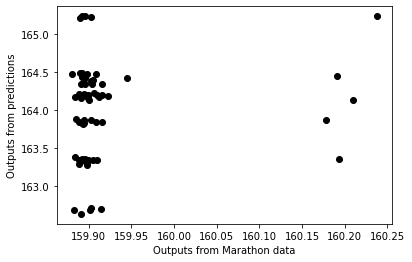

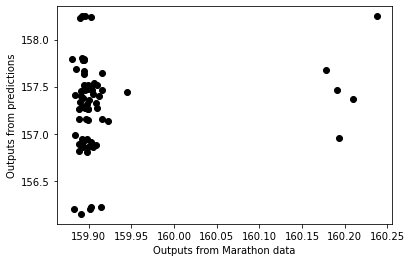

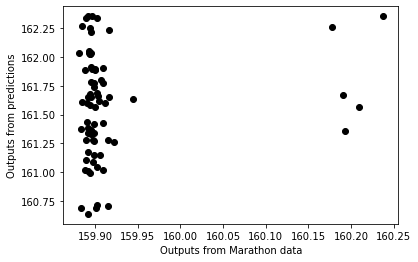

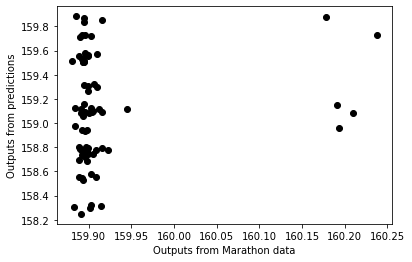

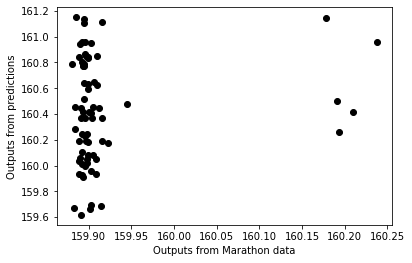

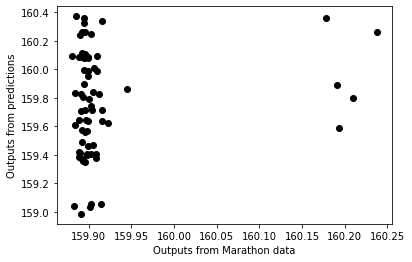

In [12]:
for ep in range(1, epochs+1):
    train(ep)
    ax = evaluate()  
#     if (ep == epochs):
#         figname = "tcn_epoch_tune_kernel5"
#         ax.figure.savefig(figname, dpi=300)

In [21]:
# net = Net(config["l1"], config["l2"])
# optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

# if checkpoint_dir:
#     checkpoint = os.path.join(checkpoint_dir, "checkpoint")
#     model_state, optimizer_state = torch.load(checkpoint)
#     net.load_state_dict(model_state)
#     optimizer.load_state_dict(optimizer_state)

def train_param(config, checkpoint_dir=None, data_dir=None):
    global lr
    
    input_channels = 14 # # of input features
    n_classes = 1  #size of each output sample; output feature sizes of y_pred

    percent_train = config["percent"]
    X_train, Y_train, X_test, Y_test = data_generator(percent, seq_length, r"C:\Users\e177321\Documents\data\Marathon_data.csv")
    #log_interval = 100 #args.log_interval; 'report interval (default: 100')
    nhid = config["nhid"]
    levels = config["levels"]
    log_interval = 10
    channel_sizes = [nhid]*levels #[args.nhid]*args.levels; number of hidden units per layer * # of levels

    model = TCN(input_channels, n_classes, channel_sizes, kernel_size=config["kernel"], dropout=config["drop"])
    #model = TCN(input_channels, n_classes, channel_sizes, kernel_size=32, dropout=0.0)
    lr = 4e-3 # learning rate is defaulted to be 0.0040
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"]) #optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)
    #optimizer = torch.optim.Adam(model.parameters(), lr=4e-3) #optimizer = 
                                                            #getattr(optim, args.optim)(model.parameters(), lr=lr)
    model.train()

#     if checkpoint_dir:
#         checkpoint = os.path.join(checkpoint_dir, "checkpoint")
#         model_state, optimizer_state = torch.load(checkpoint)
#         TCN.load_state_dict(model_state)
#         optimizer.load_state_dict(optimizer_state)

    for epochs in range(10):
        print("ep = ", epochs, "\n")
        batch_idx = 1
        total_loss = 0
        batch_size = config["batch_size"]
        for i in range(0, X_train.size(0), batch_size):
            if i + batch_size > X_train.size(0):
                x, y = X_train[i:], Y_train[i:]
            else:
                x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]

            optimizer.zero_grad()
            output = model(x)
            loss = torch.nn.functional.mse_loss(output, y)
            loss.backward()
            if clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            batch_idx += 1
            total_loss += loss.item()

            print("loss.item equals: ", loss.item(), "\n")
            print("total loss = ", total_loss, "\n")

            if batch_idx % log_interval == 0:
                cur_loss = total_loss / log_interval
                processed = min(i+batch_size, X_train.size(0))
                print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                    epochs, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
                total_loss = 0

            tune.report(loss = total_loss)
        
        return total_loss

In [22]:
config = {
    "nhid": tune.choice([10,20,30,40,50,60,70]),
    "levels": tune.sample_from(lambda _: np.random.randint(1, 10)),
    "percent": tune.choice([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    "kernel": tune.sample_from(lambda _: np.random.randint(2, 9)),
    "drop": tune.sample_from(lambda _: np.random.uniform(0, 1)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16, 32])
}

In [23]:
def evaluate(best_trial):
    
    nhid = best_trial.config["nhid"]
    levels = best_trial.config["levels"]
    channel_sizes = [nhid]*levels #[args.nhid]*args.levels; number of hidden units per layer * # of levels
    best_trained_model = TCN(input_channels, n_classes, channel_sizes, best_trial.config["kernel"], best_trial.config["drop"])

    X_train, Y_train, X_test, Y_test = data_generator(percent, seq_length, r"C:\Users\e177321\Documents\data\Marathon_data.csv")
    
    best_trained_model.eval()
    with torch.no_grad():
        output = best_trained_model(X_test)
        test_loss = torch.nn.functional.mse_loss(output, Y_test)
        f, ax = plt.subplots()
        #print("Y_pred values: ", output, "\n")
        ax.scatter(Y_test, output,  color='black')
        ax.set_xlabel('Outputs from Marathon data')
        ax.set_ylabel('Outputs from predictions')
        print('\nBest test set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss

In [24]:
def main(filename, num_samples=10, max_num_epochs=15,gpus_per_trial=0):
    config = {
        "nhid": tune.choice([10,20,30,40,50,60,70]),
        "levels": tune.sample_from(lambda _: np.random.randint(1, 10)),
        "percent": tune.choice([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
        "kernel": tune.sample_from(lambda _: np.random.randint(2, 9)),
        "drop": tune.sample_from(lambda _: np.random.uniform(0, 1)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16, 32]),
    }
    
    outlog = filename + ".log"
    errlog = filename + ".log"
    print("writing outputs to log files\n")

    #print("epochs = ", ep, "\n")
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    result = tune.run(
        tune.with_parameters(train_param),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        metric="loss",
        mode="min",
        num_samples=num_samples,
        scheduler=scheduler, fail_fast=True,
        verbose = 1,
        local_dir="./temp/", resume="AUTO",
        log_to_file=(outlog, errlog)
    )

    best_trial = result.get_best_trial("loss")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
         best_trial.last_result["loss"]))
    
    test_loss = evaluate(best_trial)
    return result, test_loss

2021-11-05 16:26:01,810	INFO tune.py:630 -- Total run time: 33.92 seconds (33.73 seconds for the tuning loop).


Best trial config: {'nhid': 30, 'levels': 4, 'percent': 0.6, 'kernel': 5, 'drop': 0.7228695200102911, 'lr': 0.003186756383770736, 'batch_size': 16}
Best trial final validation loss: 16558.6201171875
converted X_bot  torch.Size([274, 14]) and y_bot  torch.Size([274, 1])  to tensors


Best test set: Average loss: 25923.267578

                     loss  time_this_iter_s  done timesteps_total  \
trial_id                                                            
83bd8_00000  3.144182e+05          0.030300  True            None   
83bd8_00001  1.531403e+05          0.010114  True            None   
83bd8_00002  2.574392e+04          2.248368  True            None   
83bd8_00003  1.655862e+04          0.030267  True            None   
83bd8_00004  2.542810e+04          2.184798  True            None   
83bd8_00005  2.658263e+04          1.960042  True            None   
83bd8_00006  5.504107e+04          0.015624  True            None   
83bd8_00007  2.526543e+04          2.210739  True   

converted X_bot  torch.Size([274, 14]) and y_bot  torch.Size([274, 1])  to tensors


Best test set: Average loss: 24286.802734



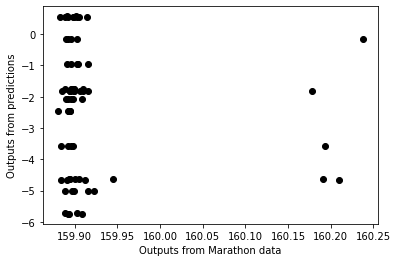

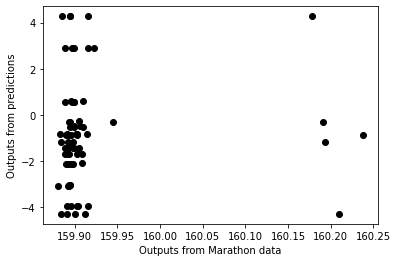

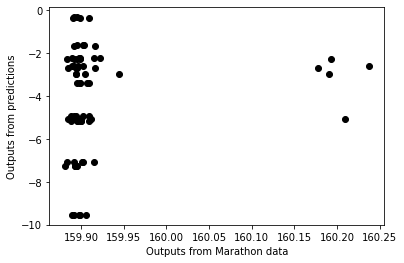

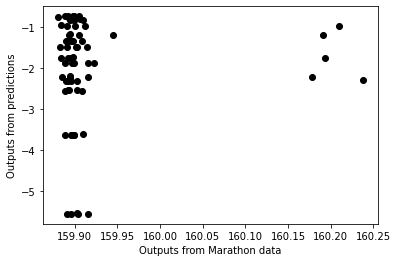

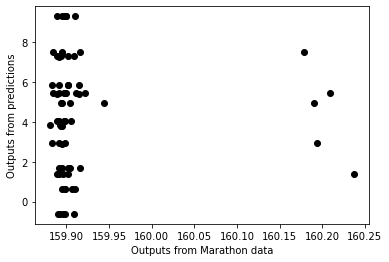

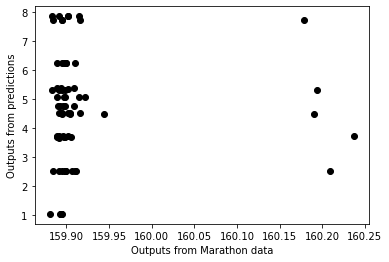

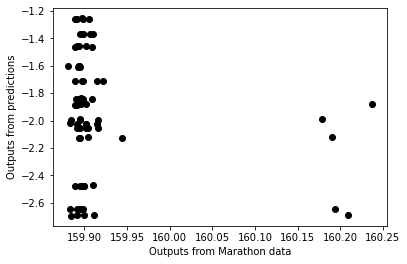

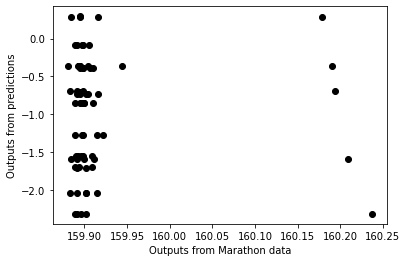

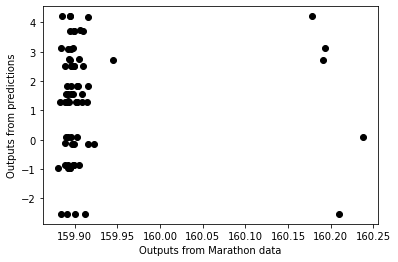

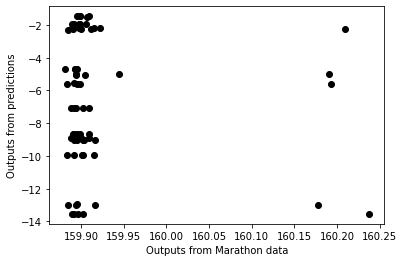

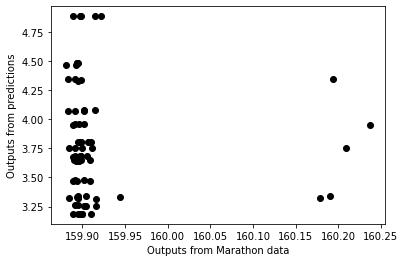

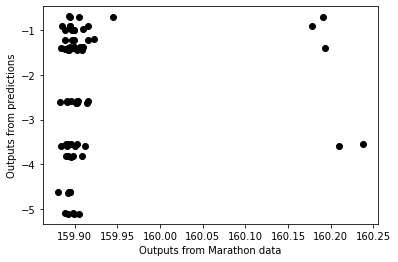

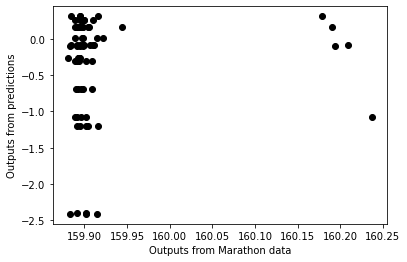

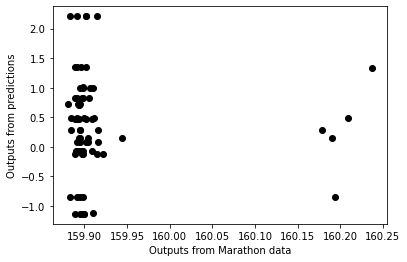

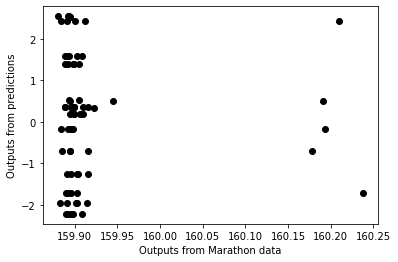

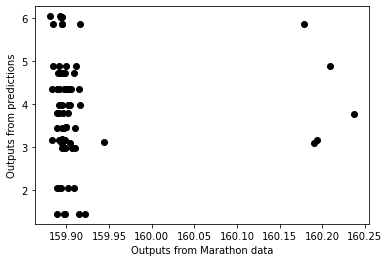

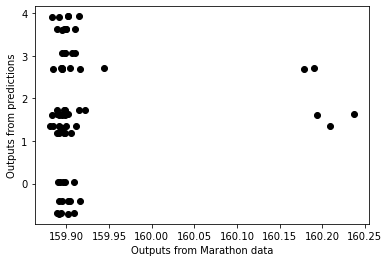

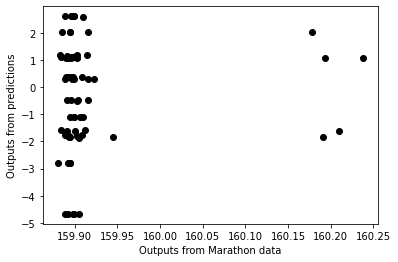

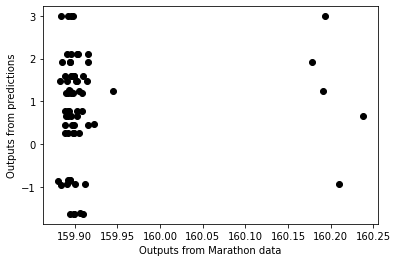

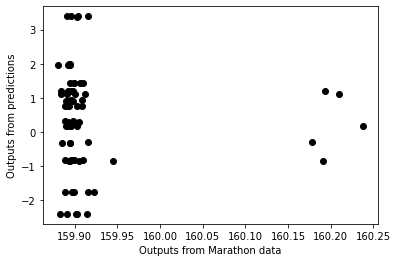

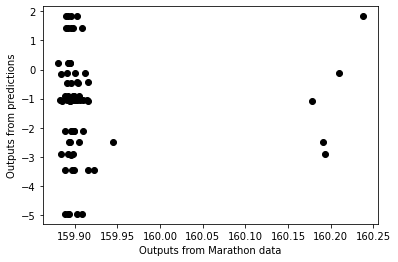

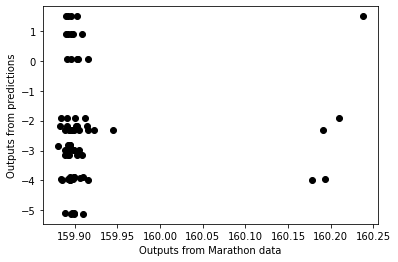

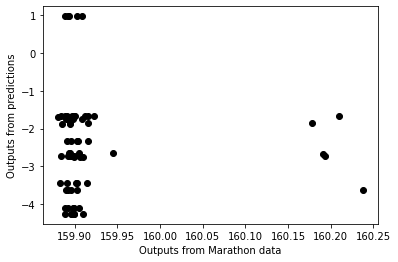

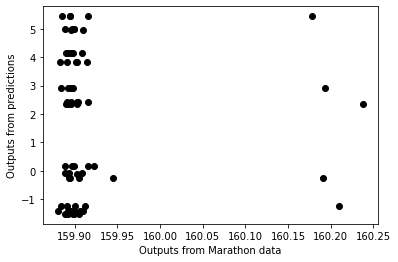

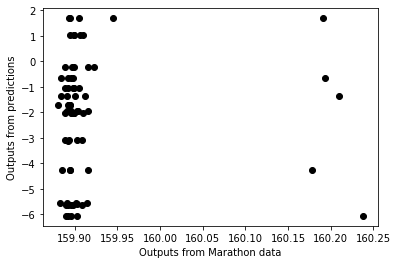

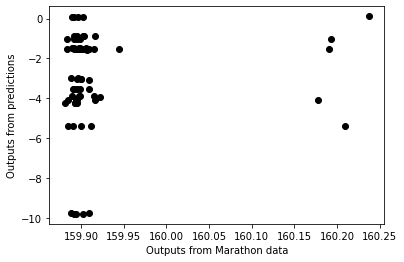

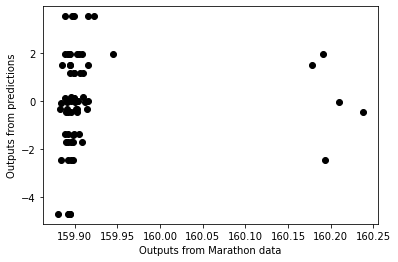

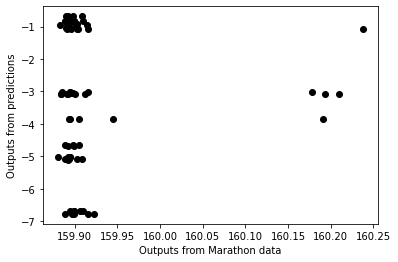

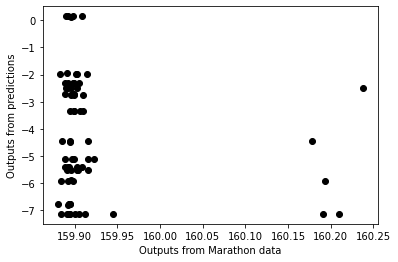

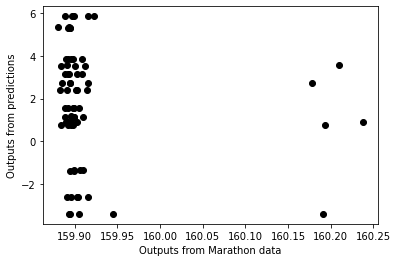

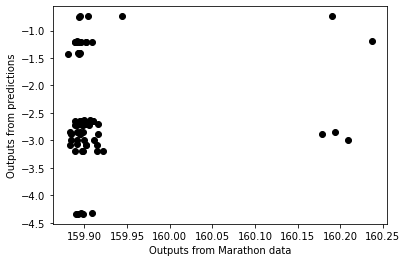

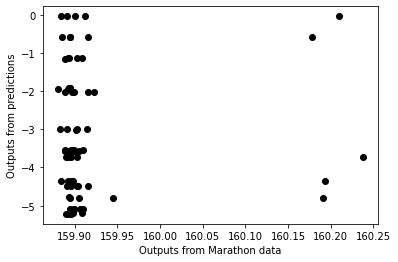

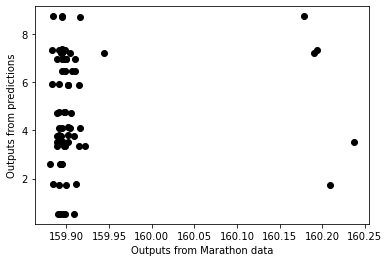

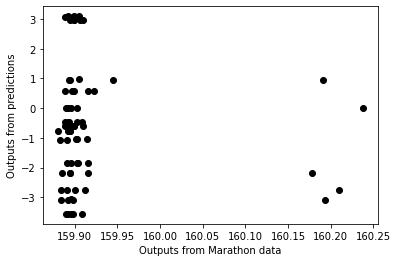

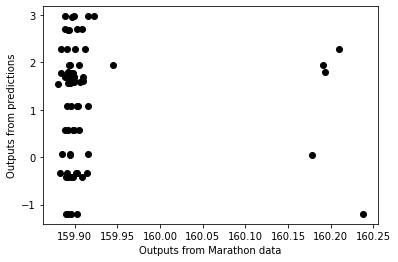

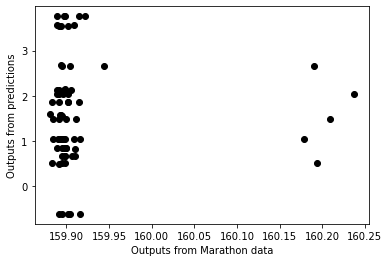

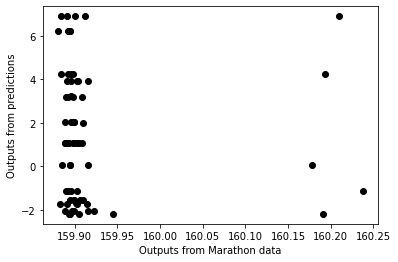

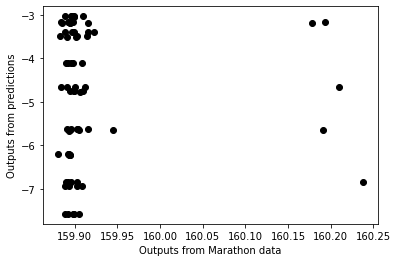

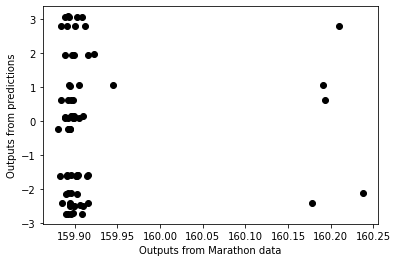

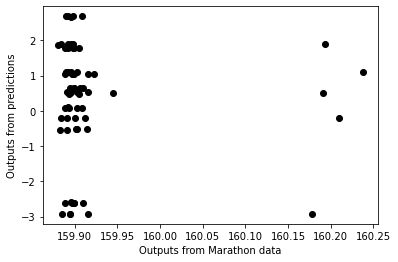

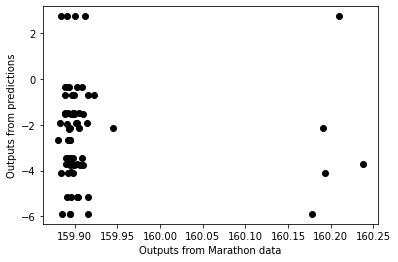

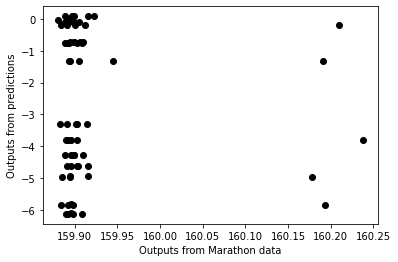

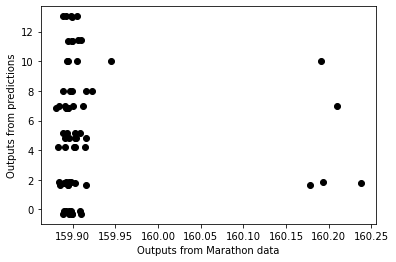

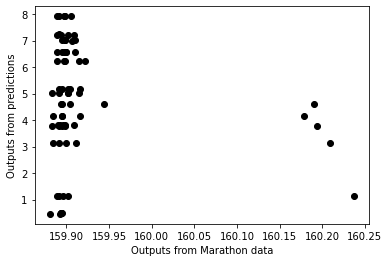

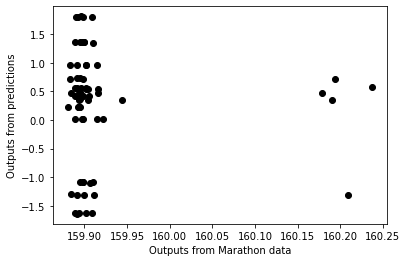

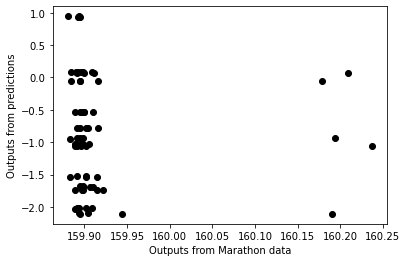

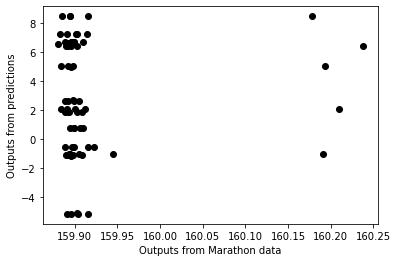

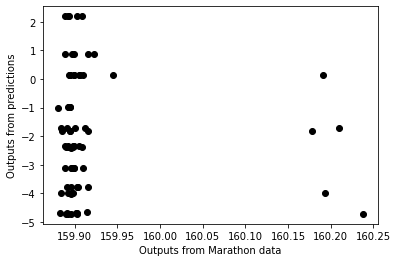

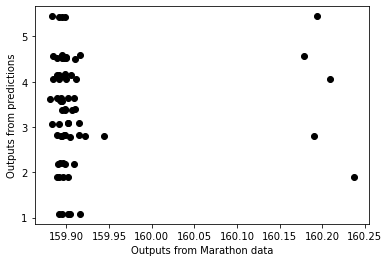

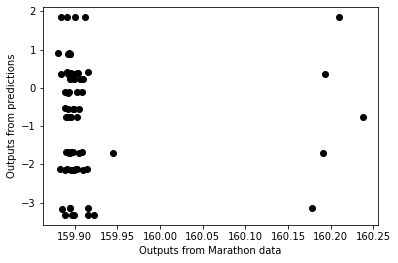

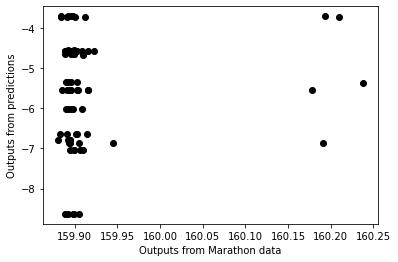

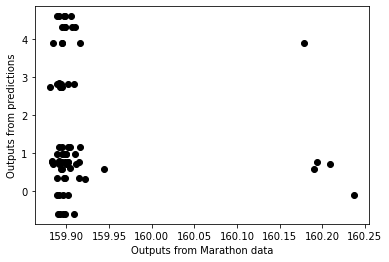

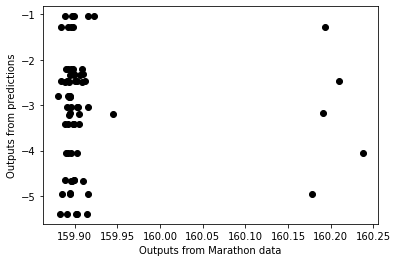

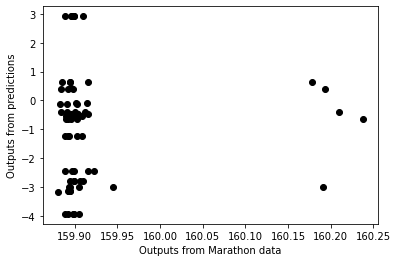

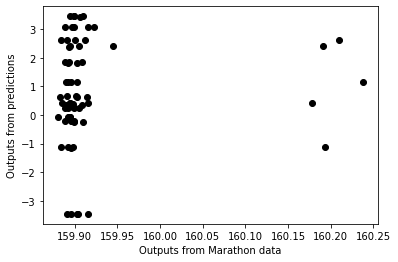

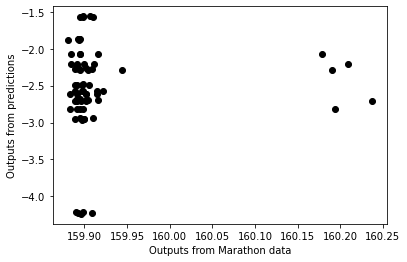

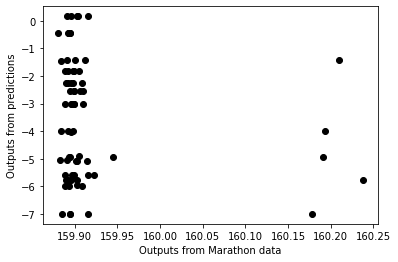

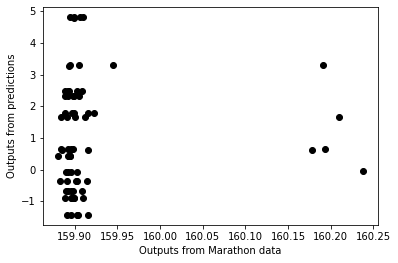

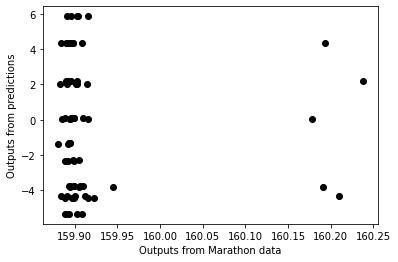

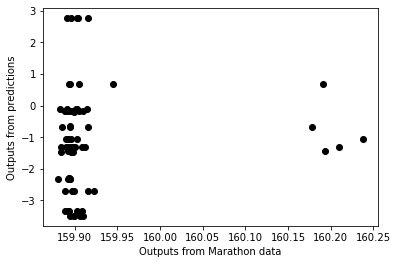

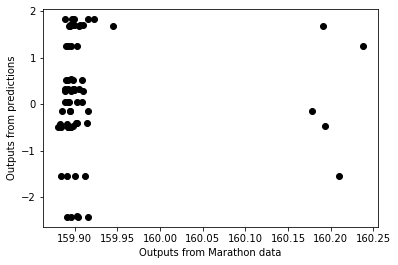

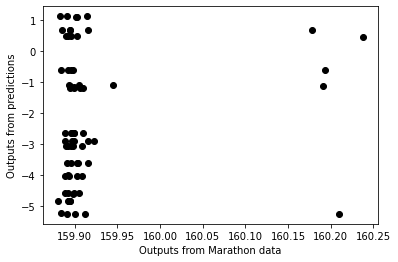

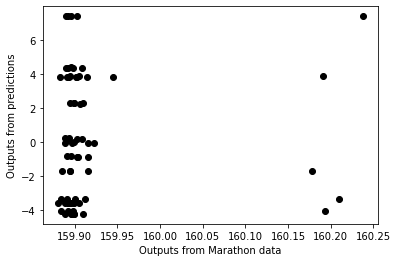

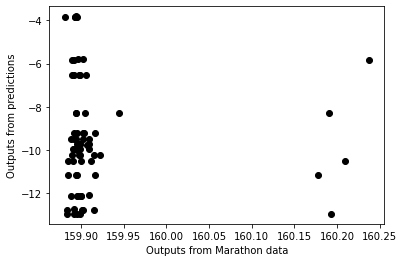

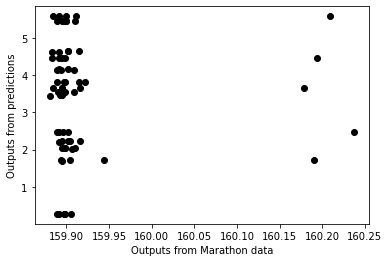

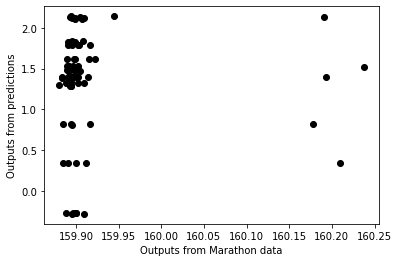

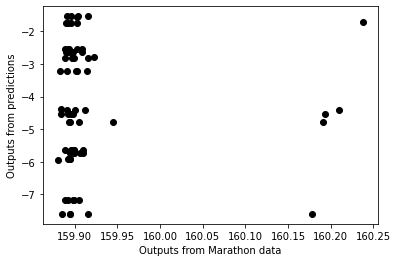

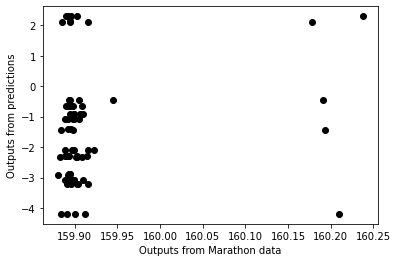

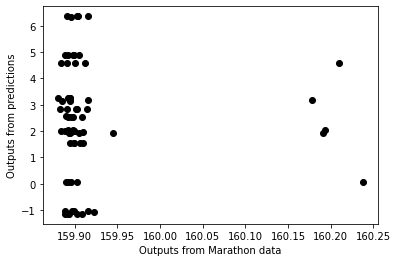

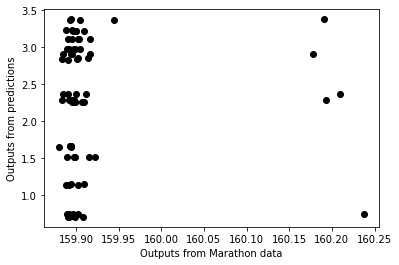

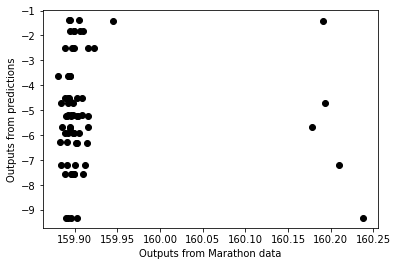

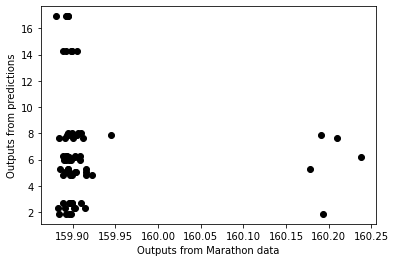

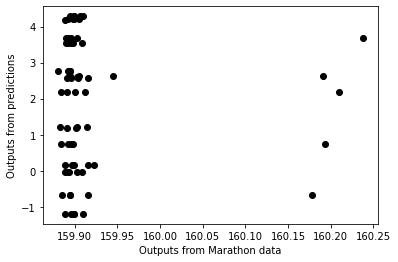

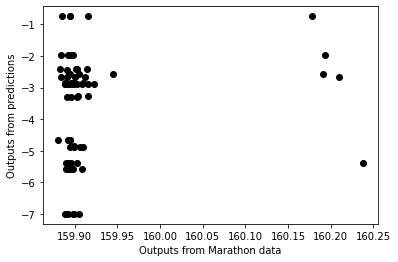

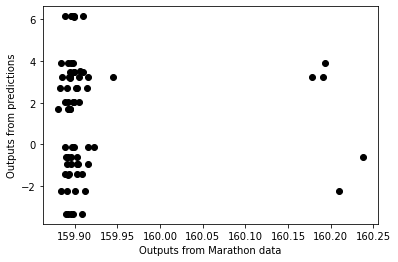

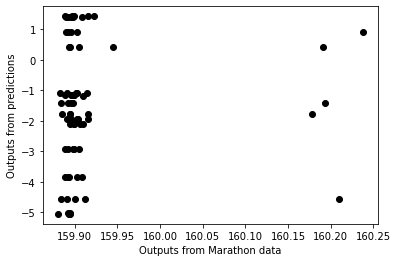

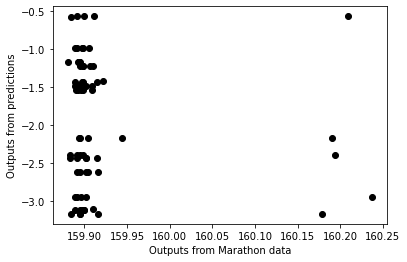

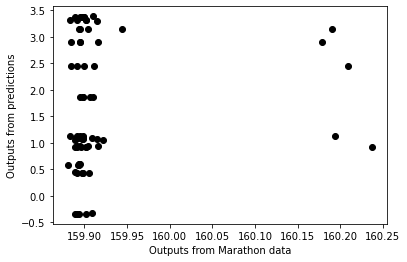

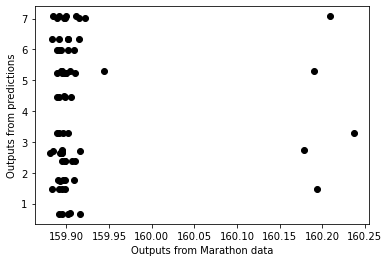

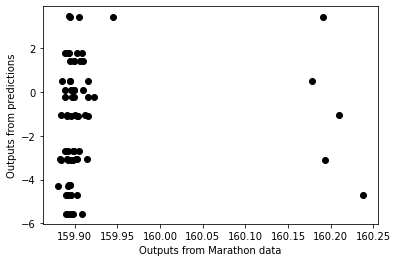

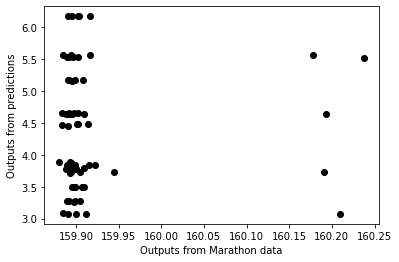

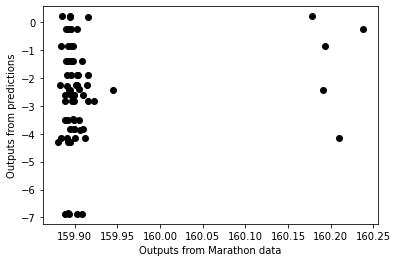

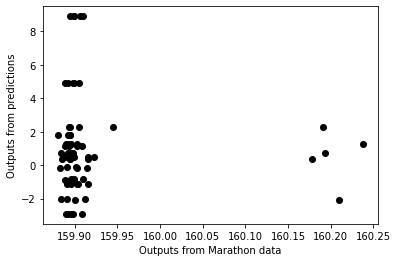

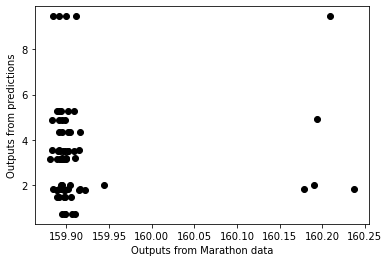

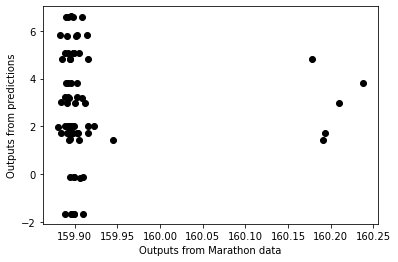

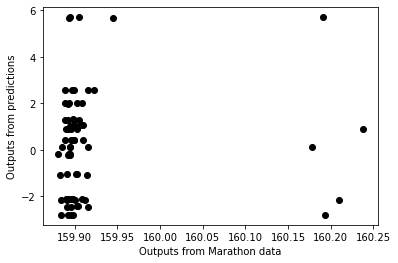

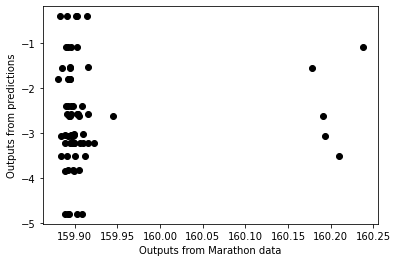

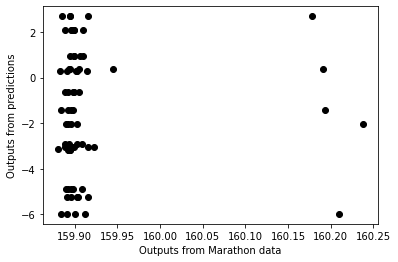

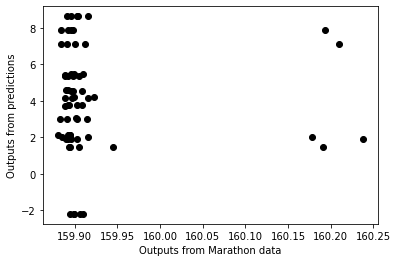

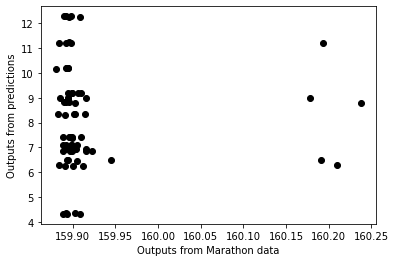

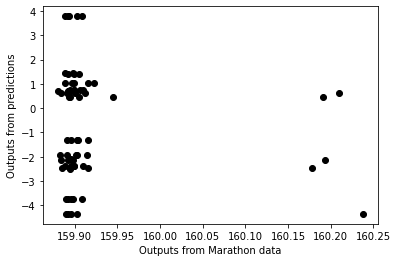

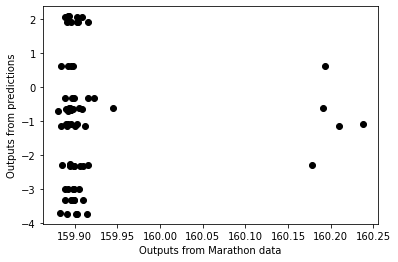

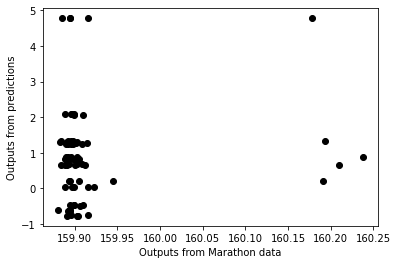

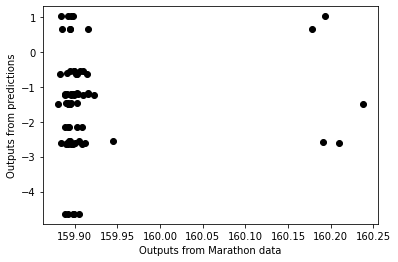

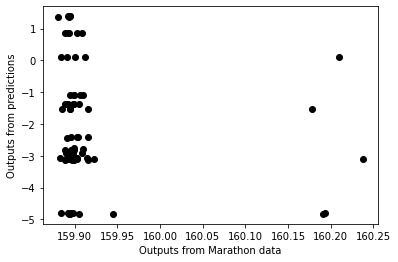

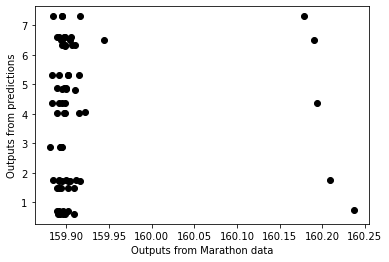

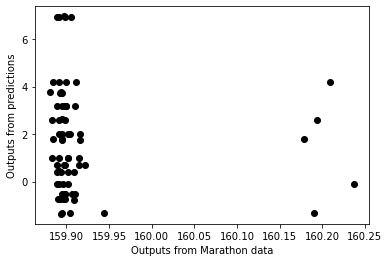

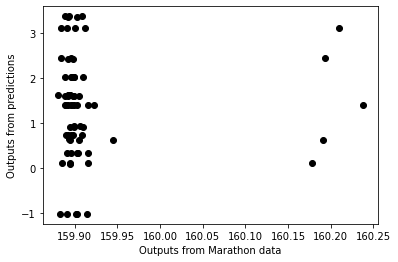

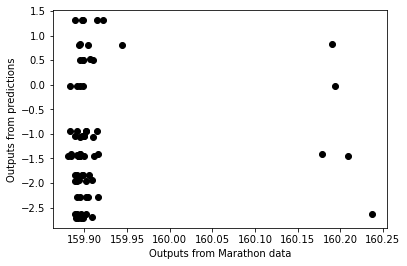

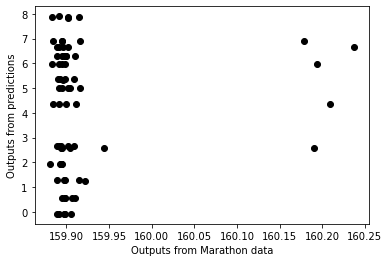

In [29]:
filename = "hyperparameter_tune_final_run"
filetxt = filename + ".txt"
with open(filetxt, 'a') as f:
    for i in range(50):
        best_result, test_loss = main(filename, num_samples = 20)
        df = best_result.results_df
        print(df)
        best_trial = best_result.get_best_trial("loss")
        f.write("Best trial config: {}".format(best_trial.config))
        f.write("\n")
        f.write("Best trial final validation loss: {}".format(
             best_trial.last_result["loss"]))
        test_loss = evaluate(best_trial)
        f.write('\nBest test set: Average loss: {:.6f}\n'.format(test_loss.item()))
f.close()